# DeepLab V3+ mit RGB Bildern und image net

## SetUp

In [ ]:
!pip install rasterio
!pip install tensorflow segmentation-models
!pip install segmentation-models --no-deps
!pip install keras-applications keras-preprocessing
!pip install dash-bootstrap-components
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


In [ ]:
import tensorflow as tf
import numpy as np
import rasterio
import os
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raster_path = "/content/drive/MyDrive/GroundTruthData/Rasterdateien_RGB"  # Folder containing TIFF raster images
mask_path = "/content/drive/MyDrive/GroundTruthData/SegmentationMasks"  # Folder containing PNG segmentation masks
labelmap_path = "/content/drive/MyDrive/GroundTruthData/labelmap.txt"  # Path to labelmap

## Preperation

In [ ]:
# Schritt 1: Einlesen der Labelmap
labelmap = {}
color_to_index = {}
index_to_label = {}

with open(labelmap_path, "r") as file:
    for line in file:
        if not line.startswith("#") and line.strip():
            label, color_rgb, *_ = line.split(":")
            r, g, b = map(int, color_rgb.split(","))
            color = (r, g, b)

            # Labelmap und Mappings erstellen
            labelmap[color] = label
            index = len(color_to_index)
            color_to_index[color] = index
            index_to_label[index] = label

num_classes = len(color_to_index)
print(f"Labelmap geladen mit {num_classes} Klassen.")

# Schritt 2: Rasterbilder und Masken laden
def load_raster_image(filepath):
    if isinstance(filepath, tf.Tensor):
        filepath = filepath.numpy().decode("utf-8")

    with rasterio.open(filepath) as src:
        image = np.stack([src.read(i) for i in range(1, src.count + 1)], axis=-1)
        image = image.astype(np.float32) / 255.0  # Normalisierung
    return image

def load_mask(filepath):
    global color_to_index
    if isinstance(filepath, tf.Tensor):
        filepath = filepath.numpy().decode("utf-8")

    mask = tf.io.read_file(filepath)
    mask = tf.image.decode_png(mask, channels=3).numpy()

    label_mask = np.zeros(mask.shape[:2], dtype=np.int32)
    for color, index in color_to_index.items():
        matches = np.all(mask == color, axis=-1)
        label_mask[matches] = index

    return label_mask

# Schritt 3: Datenvorverarbeitung
def preprocess_image_and_mask(image_path, mask_path, target_size):
    image = tf.py_function(func=load_raster_image, inp=[image_path], Tout=tf.float32)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, target_size, method='bilinear')

    mask = tf.py_function(func=load_mask, inp=[mask_path], Tout=tf.int32)
    mask.set_shape([None, None])
    mask = tf.image.resize(mask[..., tf.newaxis], target_size, method='nearest')
    mask = tf.squeeze(mask)
    mask = tf.one_hot(mask, depth=num_classes)
    return image, mask

# Schritt 4: Dataset erstellen
def create_dataset(image_paths, mask_paths, target_size=(512, 512)):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(
        lambda x, y: preprocess_image_and_mask(x, y, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset.prefetch(tf.data.AUTOTUNE)

# Schritt 5: Data Augmentation
def augment_dataset(dataset):
    augment_layer = tf.keras.Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomZoom(0.2)
    ])
    augmented_dataset = dataset.map(lambda x, y: (augment_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return augmented_dataset

# Schritt 6: Klassen-Gewichte berechnen
def calculate_class_weights(masks, num_classes):
    class_counts = np.zeros(num_classes, dtype=np.int64)
    for mask in masks:
        unique, counts = np.unique(mask, return_counts=True)
        for cls, count in zip(unique, counts):
            if cls < num_classes:
                class_counts[cls] += count

    total_pixels = np.sum(class_counts)
    class_weights = total_pixels / (num_classes * class_counts)
    class_weights = np.where(class_counts == 0, 0, class_weights)
    return class_weights.astype(np.float32)  # In float32 konvertieren

# Schritt 7: Gewichtete Verlustfunktion
def weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        y_true_indices = tf.argmax(y_true, axis=-1)
        weights = tf.gather(class_weights, y_true_indices)
        cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        unweighted_loss = cce(y_true, y_pred)
        weighted_loss = weights * unweighted_loss
        return tf.reduce_mean(weighted_loss)
    return loss

# Schritt 9: Train- und Validierungssplits
image_paths = sorted([os.path.join(raster_path, f) for f in os.listdir(raster_path)])
mask_paths = sorted([os.path.join(mask_path, f) for f in os.listdir(mask_path)])
split = int(0.8 * len(image_paths))
train_images, val_images = image_paths[:split], image_paths[split:]
train_masks, val_masks = mask_paths[:split], mask_paths[split:]

train_dataset = create_dataset(train_images, train_masks)
val_dataset = create_dataset(val_images, val_masks)

# Klassen-Gewichte berechnen
train_masks_data = [load_mask(mask) for mask in train_masks]
class_weights = calculate_class_weights(train_masks_data, num_classes)

# Loss-Funktion mit Klassen-Gewichten
loss_fn = weighted_categorical_crossentropy(class_weights)

Labelmap geladen mit 10 Klassen.


<ipython-input-6-93fc14d1edb9>:89: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_pixels / (num_classes * class_counts)


## Modell aufsetzen

In [ ]:
# DeepLabV3+ Modell mit 10 Klassen
def deeplabv3_plus_custom(input_shape=(512, 512, 3), num_classes=10, use_imagenet=True):
    inputs = Input(shape=input_shape)

    # Vortrainierte Gewichte verwenden, falls aktiviert
    if use_imagenet:
        base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    else:
        base_model = ResNet50(include_top=False, weights=None, input_tensor=inputs)

    def aspp(x):
        shape = x.shape[1:3]
        b0 = Conv2D(256, (1, 1), padding="same", activation="relu")(x)
        b1 = Conv2D(256, (3, 3), padding="same", dilation_rate=6, activation="relu")(x)
        b2 = Conv2D(256, (3, 3), padding="same", dilation_rate=12, activation="relu")(x)
        b3 = Conv2D(256, (3, 3), padding="same", dilation_rate=18, activation="relu")(x)
        b4 = GlobalAveragePooling2D()(x)
        b4 = Reshape((1, 1, b4.shape[-1]))(b4)
        b4 = Conv2D(256, (1, 1), padding="same", activation="relu")(b4)
        b4 = Resizing(shape[0], shape[1])(b4)
        return Conv2D(256, (1, 1), padding="same", activation="relu")(Concatenate()([b0, b1, b2, b3, b4]))

    x = aspp(base_model.output)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Concatenate()([x, base_model.get_layer("conv4_block6_2_relu").output])
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Resizing(512, 512)(x)
    x = Conv2D(num_classes, (1, 1), activation="softmax")(x)

    return Model(inputs=inputs, outputs=x)



In [ ]:
# Initialisiere Logging-Datei
log_path = "/content/drive/MyDrive/DeepLabV3/RGB_experiments_log.csv"
if not os.path.exists(log_path):
    log_df = pd.DataFrame(columns=[
        "Experiment_ID", "Learning_Rate", "Batch_Size", "Data_Augmentation",
        "Train_Loss", "Val_Loss", "Train_MeanIoU", "Val_MeanIoU"
    ])
else:
    log_df = pd.read_csv(log_path)

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# Neue Augmentationsfunktion: Weniger aggressiv
def light_augmentation():
    return tf.keras.Sequential([
        RandomFlip("horizontal_and_vertical"),  # Leichte Spiegelung
        RandomRotation(0.1),  # Rotation bis max ±10°
        RandomZoom(0.1)  # Zoomen bis ±10%
    ])

# Dataset mit weniger aggressiver Augmentation erweitern
def augment_dataset_light(dataset):
    augment_layer = light_augmentation()
    return dataset.map(lambda x, y: (augment_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Konfigurationen für das Experiment
num_classes = 10  # Anzahl der Klassen
epochs = 50  # Maximale Anzahl der Epochen
batch_size = 32
learning_rate = 0.0001

# Early Stopping einstellen
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Log-Datei initialisieren
log_df = pd.DataFrame(columns=["Experiment_ID", "Data_Augmentation", "Dataset_Size",
                                "Train_Loss", "Val_Loss", "Train_Accuracy", "Val_Accuracy"])

# Experiment durchführen
experiment_id = "Try"
augmentation = True
dataset_size = "Full"  # Voller Datensatz

print(f"Experiment {experiment_id} - Augmentation: {augmentation}, Dataset: {dataset_size}")

# Dataset erstellen
train_ds = create_dataset(train_images, train_masks).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Augmentation anwenden
if augmentation:
    train_ds = augment_dataset_light(train_ds)

# Klassen-Gewichte berechnen
train_masks_data = [load_mask(mask) for mask in train_masks]
class_weights = calculate_class_weights(train_masks_data, num_classes)
loss_fn = weighted_categorical_crossentropy(class_weights)

# Modell erstellen und kompilieren
model = deeplabv3_plus_custom(input_shape=(512, 512, 3), num_classes=num_classes)
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=loss_fn,
    metrics=["accuracy"]
)

# Checkpoint speichern
checkpoint_path = f"/content/drive/MyDrive/DeepLabV3/RGB_experiment_{experiment_id}.keras"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Ergebnisse protokollieren
new_row = {
    "Experiment_ID": experiment_id,
    "Data_Augmentation": augmentation,
    "Dataset_Size": dataset_size,
    "Train_Loss": history.history["loss"][-1],
    "Val_Loss": history.history["val_loss"][-1],
    "Train_Accuracy": history.history["accuracy"][-1],
    "Val_Accuracy": history.history["val_accuracy"][-1],
}
log_df = pd.concat([log_df, pd.DataFrame([new_row])], ignore_index=True)

# Ergebnisse speichern und anzeigen
log_df.to_csv(log_path, index=False)
print(f"Experiment {experiment_id} abgeschlossen. Ergebnisse in {log_path} gespeichert.")


Experiment Try - Augmentation: True, Dataset: Full


<ipython-input-6-93fc14d1edb9>:89: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_pixels / (num_classes * class_counts)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90s/step - accuracy: 0.1056 - loss: 2.0580
Epoch 1: val_loss improved from inf to 1.64252, saving model to /content/drive/MyDrive/DeepLabV3/RGB_experiment_Try.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 115s 115s/step - accuracy: 0.1056 - loss: 2.0580 - val_accuracy: 0.0595 - val_loss: 1.6425
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1265 - loss: 2.0105
Epoch 2: val_loss improved from 1.64252 to 1.61812, saving model to /content/drive/MyDrive/DeepLabV3/RGB_experiment_Try.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.1265 - loss: 2.0105 - val_accuracy: 0.0492 - val_loss: 1.6181
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1189 - loss: 1.9650
Epoch 3: val_loss improved from 1.61812 to 1.59838, saving model to /content/drive/MyDrive/DeepLabV3/RGB_experiment_Try.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.1189 - loss: 1.9650 - val_accuracy: 0.0400 - val_loss: 1.5984
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

<ipython-input-10-81f466e5c38a>:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_row])], ignore_index=True)


## Analyse

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


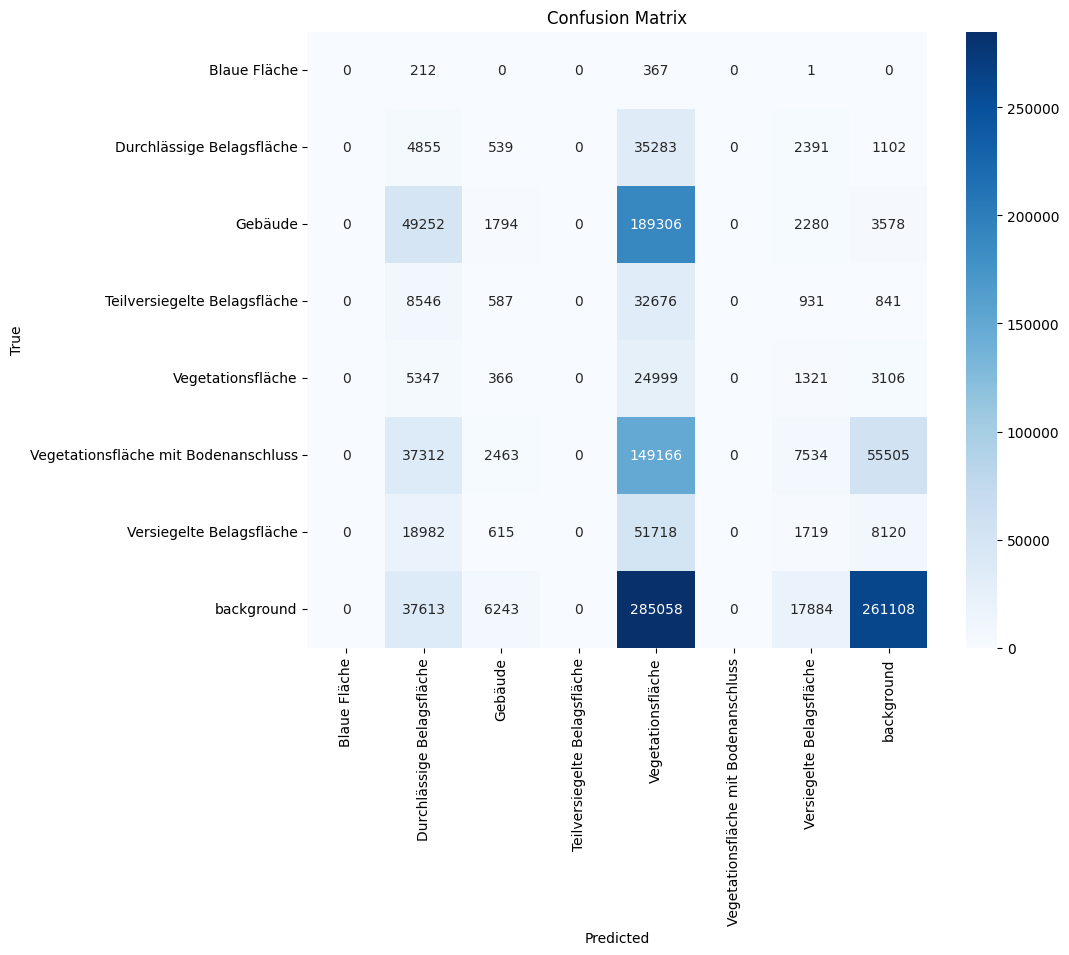

Classification Report:
                                       precision    recall  f1-score   support

                        Blaue Fläche       0.00      0.00      0.00       580
           Durchlässige Belagsfläche       0.03      0.11      0.05     44170
                             Gebäude       0.14      0.01      0.01    246210
        Teilversiegelte Belagsfläche       0.00      0.00      0.00     43581
                   Vegetationsfläche       0.03      0.71      0.06     35139
Vegetationsfläche mit Bodenanschluss       0.00      0.00      0.00    251980
            Versiegelte Belagsfläche       0.05      0.02      0.03     81154
                          background       0.78      0.43      0.55    607906

                            accuracy                           0.22   1310720
                           macro avg       0.13      0.16      0.09   1310720
                        weighted avg       0.40      0.22      0.27   1310720


Overall Accuracy: 0.2247
Mean IoU (m

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Dynamische Anpassung der Zielklassen
def get_present_classes(y_true, y_pred, target_classes):
    # Kombiniere y_true und y_pred, um vorhandene Klassen zu identifizieren
    present_classes = set(y_true + y_pred)
    # Filtere nur die Klassen aus target_classes, die tatsächlich vorhanden sind
    filtered_classes = {label: idx for label, idx in target_classes.items() if idx in present_classes}
    return filtered_classes

# Analyse der Validierungsdaten mit zusätzlichen Metriken
def analyze_model_performance_dynamic(model, val_dataset, labelmap, num_classes):
    # Zielklassen aus Labelmap
    target_classes = {label: idx for idx, label in enumerate(labelmap.values())}

    y_true, y_pred = [], []

    # Vorhersagen generieren
    for images, masks in val_dataset:
        predictions = model.predict(images)
        y_true.extend(tf.argmax(masks, axis=-1).numpy().flatten())
        y_pred.extend(tf.argmax(predictions, axis=-1).numpy().flatten())

    # Dynamische Zielklassen anpassen
    adjusted_classes = get_present_classes(y_true, y_pred, target_classes)
    adjusted_labels = list(adjusted_classes.values())
    adjusted_names = list(adjusted_classes.keys())

    # Confusion Matrix
    cm = confusion_matrix(
        [y for y in y_true if y in adjusted_labels],
        [y for y in y_pred if y in adjusted_labels],
        labels=adjusted_labels
    )

    # IoU berechnen
    def calculate_class_iou(cm, class_index):
        true_positive = cm[class_index, class_index]
        false_positive = cm[:, class_index].sum() - true_positive
        false_negative = cm[class_index, :].sum() - true_positive
        union = true_positive + false_positive + false_negative
        return true_positive / union if union > 0 else 0

    # IoU für jede Klasse berechnen
    iou_scores = {}
    for class_name, class_index in adjusted_classes.items():
        iou_scores[class_name] = calculate_class_iou(cm, adjusted_labels.index(class_index))

    # Mean IoU (mIoU) berechnen
    mean_iou = np.mean(list(iou_scores.values()))

    # Overall Accuracy berechnen
    overall_accuracy = accuracy_score(y_true, y_pred)

    # Overall F1-Score berechnen
    overall_f1_score = f1_score(
        [y for y in y_true if y in adjusted_labels],
        [y for y in y_pred if y in adjusted_labels],
        average="macro",
        zero_division=0
    )

    # Konfusionsmatrix visualisieren
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=adjusted_names,
        yticklabels=adjusted_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Klassifikationsbericht
    report = classification_report(
        [y for y in y_true if y in adjusted_labels],
        [y for y in y_pred if y in adjusted_labels],
        target_names=adjusted_names,
        zero_division=0
    )
    print("Classification Report:\n", report)

    # Ausgabe globaler Metriken
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
    print(f"Mean IoU (mIoU): {mean_iou:.4f}")
    print(f"Overall F1-Score: {overall_f1_score:.4f}")

    # IoU-Werte ausgeben
    print("\nClass-Specific IoU Scores:")
    for class_name, iou in iou_scores.items():
        print(f"{class_name}: {iou:.2f}")

    return cm, mean_iou, overall_accuracy, overall_f1_score, iou_scores

# Analyse starten
conf_matrix_dynamic, mean_iou_dynamic, accuracy_dynamic, f1_score_dynamic, class_iou_scores_dynamic = analyze_model_performance_dynamic(
    model,
    val_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
    labelmap,
    num_classes
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Unique classes in y_true after removing background: {8, 2, 5}
Unique classes in y_pred after removing background: {8, 2}


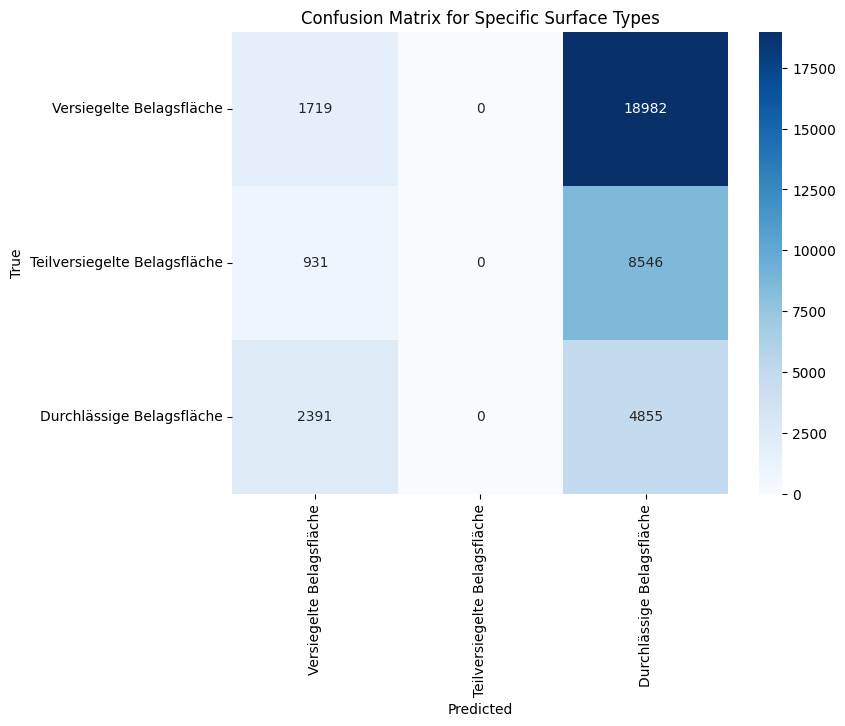

Classification Report for Specific Surface Types:
                               precision    recall  f1-score   support

    Versiegelte Belagsfläche       0.15      0.67      0.25      7246
Teilversiegelte Belagsfläche       0.00      0.00      0.00      9477
   Durchlässige Belagsfläche       0.34      0.08      0.13     20701

                    accuracy                           0.18     37424
                   macro avg       0.16      0.25      0.13     37424
                weighted avg       0.22      0.18      0.12     37424

Class-Specific IoU Scores for Specific Surface Types:
Versiegelte Belagsfläche: 0.07
Teilversiegelte Belagsfläche: 0.00
Durchlässige Belagsfläche: 0.14


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Zielklassen für die drei spezifischen Flächentypen
target_classes_focus = {
    "Versiegelte Belagsfläche": color_to_index[(255, 215, 0)],  # RGB für Versiegelt
    "Teilversiegelte Belagsfläche": color_to_index[(255, 140, 0)],  # RGB für Teilversiegelt
    "Durchlässige Belagsfläche": color_to_index[(184, 134, 11)]  # RGB für Durchlässig
}

# Analyse der spezifischen Klassen mit vollständigem Ausschluss der Hintergrundklasse
def analyze_specific_classes_cleaned(model, val_dataset, target_classes):
    y_true, y_pred = [], []

    # Vorhersagen generieren
    for images, masks in val_dataset:
        predictions = model.predict(images)
        true_classes = tf.argmax(masks, axis=-1).numpy().flatten()
        pred_classes = tf.argmax(predictions, axis=-1).numpy().flatten()

        # Filtere nur Zielklassen aus true_classes und pred_classes
        for t, p in zip(true_classes, pred_classes):
            if t in target_classes.values():
                y_true.append(t)
                y_pred.append(p if p in target_classes.values() else -1)

    # Entferne alle -1 Klassen (Hintergrund) aus y_pred
    y_true_filtered = [y for y, p in zip(y_true, y_pred) if p != -1]
    y_pred_filtered = [p for p in y_pred if p != -1]

    # Debugging: Überprüfen der Klassen nach vollständigem Entfernen
    print("Unique classes in y_true after removing background:", set(y_true_filtered))
    print("Unique classes in y_pred after removing background:", set(y_pred_filtered))

    # Confusion Matrix
    adjusted_labels = list(target_classes.values())
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=adjusted_labels)

    # IoU berechnen
    def calculate_class_iou(cm, class_index):
        true_positive = cm[class_index, class_index]
        false_positive = cm[:, class_index].sum() - true_positive
        false_negative = cm[class_index, :].sum() - true_positive
        union = true_positive + false_positive + false_negative
        return true_positive / union if union > 0 else 0

    iou_scores = {}
    for class_name, class_index in target_classes.items():
        iou_scores[class_name] = calculate_class_iou(cm, adjusted_labels.index(class_index))

    # Konfusionsmatrix visualisieren
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=list(target_classes.keys()),
        yticklabels=list(target_classes.keys())
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for Specific Surface Types")
    plt.show()

    # Klassifikationsbericht
    report = classification_report(
        y_true_filtered,
        y_pred_filtered,
        target_names=list(target_classes.keys()),
        zero_division=0
    )
    print("Classification Report for Specific Surface Types:\n", report)

    # IoU-Werte ausgeben
    print("Class-Specific IoU Scores for Specific Surface Types:")
    for class_name, iou in iou_scores.items():
        print(f"{class_name}: {iou:.2f}")

    return cm, iou_scores

# Analyse starten
conf_matrix_focus_cleaned, class_iou_scores_focus_cleaned = analyze_specific_classes_cleaned(
    model,
    val_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
    target_classes_focus
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


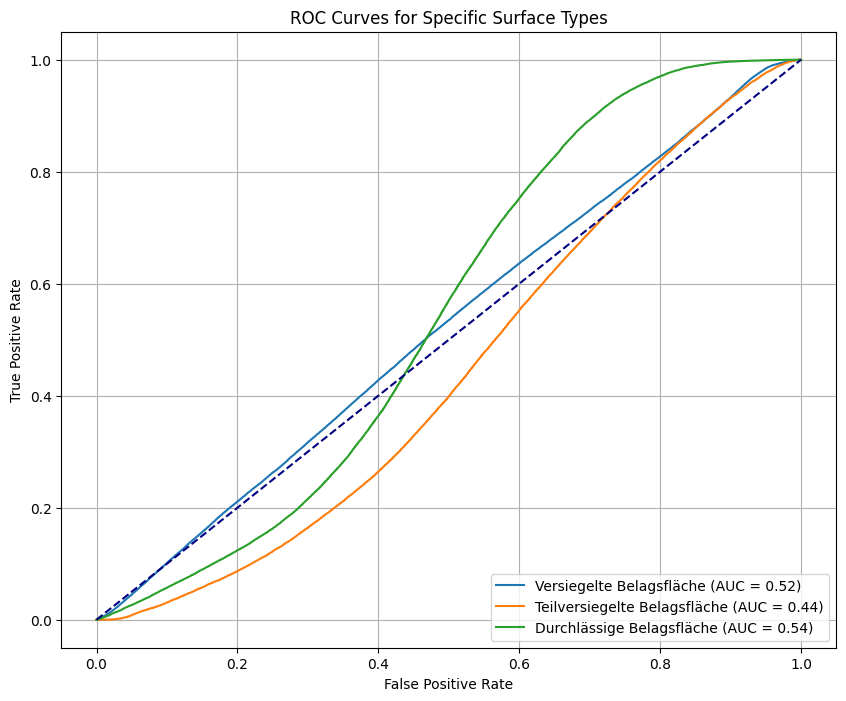

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

def plot_roc_curves(model, val_dataset, target_classes):
    # Zielklassen-Labels
    target_labels = list(target_classes.values())
    class_names = list(target_classes.keys())

    # True Labels und Predictions sammeln
    y_true, y_scores = [], []

    for images, masks in val_dataset:
        predictions = model.predict(images)  # Shape: (batch_size, height, width, num_classes)
        true_classes = tf.argmax(masks, axis=-1).numpy().flatten()  # Shape: (batch_size * height * width)
        pred_probs = predictions.reshape(-1, predictions.shape[-1])  # Shape: (total_pixels, num_classes)

        y_true.extend(true_classes)
        y_scores.extend(pred_probs)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Binarize true labels for One-vs-All ROC
    y_true_binarized = label_binarize(y_true, classes=target_labels)

    # ROC-Kurven plotten
    plt.figure(figsize=(10, 8))
    for i, class_label in enumerate(target_labels):
        if class_label not in target_labels:
            continue
        # ROC-Kurve für jede Klasse berechnen
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_scores[:, class_label])
        roc_auc = auc(fpr, tpr)

        # Plotten
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    # ROC-Kurven Formatierung
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonale Linie
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Specific Surface Types")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Plot ROC-Kurven für die drei Klassen
plot_roc_curves(
    model,
    val_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
    target_classes_focus
)


---------------------------
